### Project Proposal - Heart Disease dataset

#### Introduction

Cardiovascular disease (also known as heart disease) is a type of disease that affects the heart or blood vessels and is one of the leading causes of death in the world. Patients suffering from this disease have compromised circulatory systems due to several factors including age, sex, cholestrol levels etc. 

In this project, our goal is to predict whether or not a person has heart disease based on their vital signs. For this classification, we have chosen to use the Heart Disease dataset from the UCI Machine Learning Repository (UCI). The dataset contains many variables which affect the probability of a person suffering from heart disease. For our data analysis, we will be focusing on the following variables:

- Age - age in years
- Sex - (1=male, 0=female)
- Chest pain type (cp) - 1 = typical angina, 2 = atypical angina, 3 = non-angina pain, 4 = asymptomatic angina
- Fasting blood sugar (fbs) - fasting blood sugar in mg/dL 
- Maximum heart rate achieved - measured in beats per min (BPM)
- Exercise induced angina - 1 = yes; 0 = no
- Diagnosis - diagnosis of angiographic (heart) disease

In [1]:
# Packages needed for classification on our dataset
import altair as alt
import numpy as np
import pandas as pd
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

alt.data_transformers.disable_max_rows()
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

### Preliminary exploratory data analysis

In [2]:
# Loading the dataset using the URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

heart_disease = pd.read_csv(url, header=None)

heart_disease.columns = ("Age",
           "Sex",
           "Chest_Pain_Type",
           "Resting_Blood_Pressure",
           "Serum_Cholesterol",
           "Fasting_Blood_Sugar",
           "Resting_ECG",
           "Max_Heart_Rate",
           "Exercise_Induced_Angina",
           "ST_Depression_Exercise",
           "Peak_Exercise_ST_Segment",
           "Num_Major_Vessels_Flouro",
           "Thalassemia",
           "Diagnosis") # assigning human-readable column headings

# Filtering to include only the columns we will be using in our analysis
heart_disease_final = heart_disease.loc[:, ["Age","Sex","Chest_Pain_Type","Fasting_Blood_Sugar","Max_Heart_Rate","Exercise_Induced_Angina","Diagnosis"]]
heart_disease_final


,Age,Sex,Chest_Pain_Type,Fasting_Blood_Sugar,Max_Heart_Rate,Exercise_Induced_Angina,Diagnosis
0,63.0,1.0,1.0,1.0,150.0,0.0,0
1,67.0,1.0,4.0,0.0,108.0,1.0,2
2,67.0,1.0,4.0,0.0,129.0,1.0,1
3,37.0,1.0,3.0,0.0,187.0,0.0,0
4,41.0,0.0,2.0,0.0,172.0,0.0,0
...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,0.0,132.0,0.0,1
299,68.0,1.0,4.0,1.0,141.0,0.0,2
300,57.0,1.0,4.0,0.0,115.0,1.0,3
301,57.0,0.0,2.0,0.0,174.0,0.0,1


Since our data was already in a tidy format (each column is a single variable, each row is a single observation and each cell is a single value). Hence, the only steps we needed to take to make the dataset easier to work with were to drop all rows with Na's and change the data types of some columns. This is shown below:

In [3]:
heart_disease_final.dropna() # Removing Na's


# Age is measured in years therefore will be an integer
heart_disease_final.Age = heart_disease.Age.astype('int64') 

# Since sex is one of male or female, we convert the data type to bool
heart_disease_final.Sex = heart_disease.Sex.astype(bool) 

# A patient either has heart disease or not, hence diagnosis will also be of bool type
heart_disease_final.Diagnosis = heart_disease.Diagnosis.astype(bool) 

# Since chest pain type can only be one of 1, 2, 3, 4 hence it will be of type int64
heart_disease_final.Chest_Pain_Type = heart_disease.Chest_Pain_Type.astype('int64') 

heart_disease_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      303 non-null    int64  
 1   Sex                      303 non-null    bool   
 2   Chest_Pain_Type          303 non-null    int64  
 3   Fasting_Blood_Sugar      303 non-null    float64
 4   Max_Heart_Rate           303 non-null    float64
 5   Exercise_Induced_Angina  303 non-null    float64
 6   Diagnosis                303 non-null    bool   
dtypes: bool(2), float64(3), int64(2)
memory usage: 12.6 KB


In [4]:
heart_disease_final # The final tidy data

,Age,Sex,Chest_Pain_Type,Fasting_Blood_Sugar,Max_Heart_Rate,Exercise_Induced_Angina,Diagnosis
0,63,True,1,1.0,150.0,0.0,False
1,67,True,4,0.0,108.0,1.0,True
2,67,True,4,0.0,129.0,1.0,True
3,37,True,3,0.0,187.0,0.0,False
4,41,False,2,0.0,172.0,0.0,False
...,...,...,...,...,...,...,...
298,45,True,1,0.0,132.0,0.0,True
299,68,True,4,1.0,141.0,0.0,True
300,57,True,4,0.0,115.0,1.0,True
301,57,False,2,0.0,174.0,0.0,True


### Splitting data into training and testing data

In [5]:
heart_train, heart_test = train_test_split(heart_disease_final, test_size=0.25, random_state=123) # set the random state to be 123
print(heart_train.head())
print(heart_test.head())

     Age    Sex  Chest_Pain_Type  Fasting_Blood_Sugar  Max_Heart_Rate  \
36    43   True                4                  0.0           120.0   
148   45   True                2                  0.0           170.0   
21    58  False                1                  1.0           162.0   
187   66   True                2                  0.0           120.0   
161   77   True                4                  0.0           162.0   

     Exercise_Induced_Angina  Diagnosis  
36                       1.0       True  
148                      0.0      False  
21                       0.0      False  
187                      1.0       True  
161                      1.0       True  
     Age    Sex  Chest_Pain_Type  Fasting_Blood_Sugar  Max_Heart_Rate  \
11    56  False                2                  0.0           153.0   
292   44   True                4                  0.0           144.0   
269   42   True                3                  0.0           150.0   
268   40   True  

### Summary Tables

First, we started by creating a dataframe grouped by chest pain type to see summarized count of each variable for each chest pain type

In [6]:
# Grouping by Chest_Pain_Type to see count of each variable for every chest pain type
chest_pain_grouped = heart_train.groupby("Chest_Pain_Type").agg("count")
chest_pain_grouped

,Age,Sex,Fasting_Blood_Sugar,Max_Heart_Rate,Exercise_Induced_Angina,Diagnosis
Chest_Pain_Type,,,,,,
1,16,16,16,16,16,16
2,35,35,35,35,35,35
3,72,72,72,72,72,72
4,104,104,104,104,104,104


## We created a table in order to count the amount of chest pain type experienced in general.

In [7]:
# Selecting the needed columns to utilize in counting the amount of chest pain type experienced
chest_pain_type_count = heart_train.loc[:,["Chest_Pain_Type","Age"]]

# Grouping by chest pain type and counting how many experience each chest pain type
chest_pain_type_count = chest_pain_type_count.groupby("Chest_Pain_Type").agg(["count"]).reset_index()

# Renaming the columns into the correct names
chest_pain_type_count.columns=("Chest_Pain_Type", "Count")
chest_pain_type_count

,Chest_Pain_Type,Count
0,1,16
1,2,35
2,3,72
3,4,104


#### Count of True Diagnosis for each Chest Pain Type

We created a table that shows the chest pain type and the count of positive diagnosis (meaning the person experiencing that chest pain type was diagnosed with heart disease). 

In [8]:
# Taking only the rows where diagnosis is 1
diagnosis_true = heart_train[heart_train["Diagnosis"]==True] 
diagnosis_true

# Grouping by chest pain type and counting the variables for each class
chest_pain = diagnosis_true.groupby("Chest_Pain_Type").agg("count").reset_index()
chest_pain

# Showing only the columns Chest_Pain_Type and Diagnosis
chest_pain_true = chest_pain.loc[:, ["Chest_Pain_Type", "Diagnosis"]]
chest_pain_true.columns = ("Chest_Pain_Type", "True_Diagnosis_Count")
chest_pain_true

,Chest_Pain_Type,True_Diagnosis_Count
0,1,5
1,2,6
2,3,16
3,4,78


#### Count of False Diagnosis for each Chest Pain Type

In [9]:
# Taking only the rows where diagnosis is 1
diagnosis_false = heart_train[heart_train["Diagnosis"]==False] 
diagnosis_false

# # Grouping by chest pain type and counting the variables for each class
chest_pain = diagnosis_false.groupby("Chest_Pain_Type").agg("count").reset_index()
chest_pain

# # Showing only the columns Chest_Pain_Type and Diagnosis
chest_pain_false = chest_pain.loc[:, ["Chest_Pain_Type", "Diagnosis"]]
chest_pain_false.columns = ("Chest_Pain_Type", "False_Diagnosis_Count")
chest_pain_false

,Chest_Pain_Type,False_Diagnosis_Count
0,1,11
1,2,29
2,3,56
3,4,26


### Visualizations

We want to visualize a bar graph that displays the distribution of diagnosis for each chest pain type.

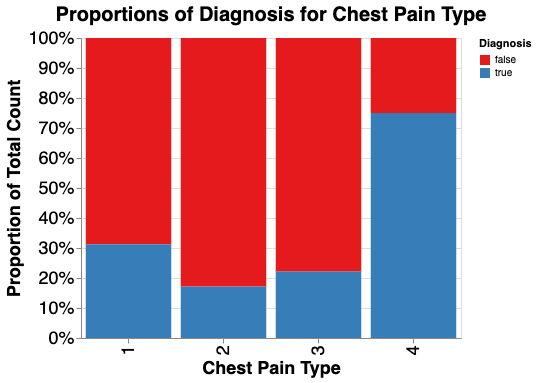

In [68]:
diagnosis_dist_plot = (
    alt.Chart(heart_train, title="Proportions of Diagnosis for Chest Pain Type" )
    .mark_bar()
    .encode(
        y=alt.Y(
            "count(Chest_Pain_Type):Q",
            stack="normalize",
            axis=alt.Axis(format="%"),
            title="Proportion of Total Count",
        ),
        x=alt.X("Chest_Pain_Type:N", title= "Chest Pain Type"),
        fill=alt.Fill(
            "Diagnosis", scale=alt.Scale(scheme="set1")
        ),  # N is to specify this is a categorical variable
    )
    .properties(width=380, height=300)
    .configure_axis(labelFontSize=18, titleFontSize=18)
    .configure_title(fontSize=20)
)
diagnosis_dist_plot

We want to visualize how chest pain type varies with age and maximum heart rate within individuals.

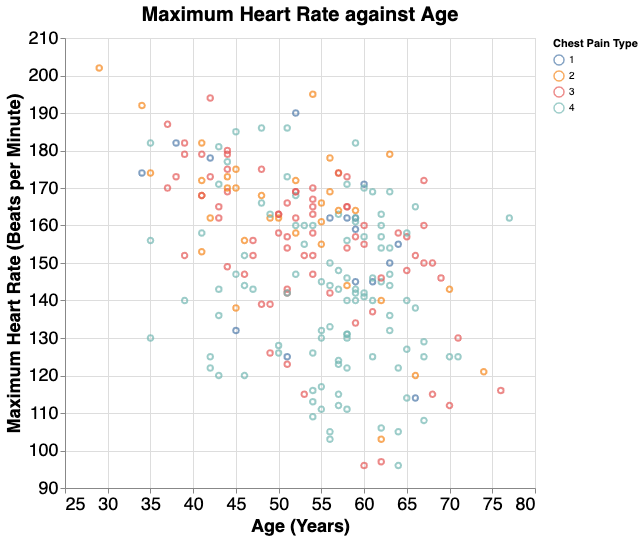

In [66]:
heart_scatter_plot = (
    alt.Chart(heart_train, title= "Maximum Heart Rate against Age")
    .mark_point()
    .encode(
        x=alt.X("Age",title= "Age (Years)",scale=alt.Scale(zero=False)),
                y=alt.Y("Max_Heart_Rate", title= "Maximum Heart Rate (Beats per Minute)", scale=alt.Scale(zero=False)),
               color=alt.Color("Chest_Pain_Type:N", title="Chest Pain Type"))
        .properties(width=470, height=450)
        .configure_axis(labelFontSize=18, titleFontSize=18)
        .configure_title(fontSize=20))
heart_scatter_plot

### Methods

We chose the variables 'Age' and 'Sex' for our analysis to know the demographics of the people included in our research, how heart disease varies with age and sex, as well as to show what demographics this analysis would be useful for in the future.

We chose 'Fasting_Blood_Sugar', 'Max_Heart_Rate' and 'Exercise_Induced_Angina' because these factors can show the health of the patient and also whether they have other diseases/conditions such as    diabetes etc.

We will use the K-classification method to run our analysis, by pulling statistical data from the dataset, in order to create a training data and a testing data that will be able to predict the type of chest pain that is associated with heart disease.

We will visualize the results of the analysis by using a stacked bar chart or a histogram, which shows the distribution of diagnosis for each chest pain type.

### Expected outcomes and significance

We expect asymptomatic angina (chest pain type 4) to be the type that most likely indicates heart disease. This is because 75% of all people experiencing asymptomatic angina from our dataset have a true diagnoses. This can also be observed in the bar chart that shows the proportions of diagnosis for each chest pain type. The graph shows that the ratio of true diagnosis to total count is the maximum for chest pain type 4. This suggests that it is more likely to be indicative of heart disease.

These findings will be able to help indicate and predict the possibility of a heart disease in regards to the type of chest pain that is experienced by each individual. This can make it easier to detect the presence of disease in the future, and take early action to prevent the disease from being fatal.

This analysis could pose questions in the future such as:
- "What factors lead to the chest pain type that is most likely to indicate heart disease?"
- "What other possible diseases might be indicated by these chest pain types?"